# Automating Stock Market Data Extraction, Transformation & Load
### Extract data from yfinance module, Transform using Pandas, Load to Excel workbook

In [1]:
# Importing the relevant modules and libraries

import yfinance as yf            # Module containing stock market data --> where we'll extract our figures from 
import yfinance.shared as shared # The shared class provides us with a way to check if an error is thrown from the data extraction 
import pandas as pd   
import openpyxl       
from datetime import date, timedelta
import yaml
import smtplib

## Safely Storing Confidential Information - User Email Addresses and Passwords

* In order to safely store and access some of my private/sensitive information, such as email addresses and passwords, I have saved a YAML file in the same directory as this Notebook containing the necessary information for this script's execution;
* This allows me to not hardcode any sensitive data onto the script and thus keep it secure by simply reading it in from a separate file;

In [5]:
credentials = yaml.load(open('credentials.yml'), Loader=yaml.FullLoader)

FROM_EMAIL = credentials['email']['from_email']
PASSWORD = credentials['email']['password']
TO_EMAIL = credentials['email']['to_email']

## Extraction  - `yfinance` module

>In order to extract data from the intended stock tickers, we first need to __define what tickers we want to fetch data for__;
>* This information will then be stored in the `xl_sheets` list-object

In [9]:
# Saving the file path from the current directory

FINAL_FILE = 'CFDv1 (2020-2025).xlsx'

In [11]:
xl_sheets = pd.ExcelFile(FINAL_FILE).sheet_names
xl_sheets

['position value',
 'dashboard',
 'orders',
 'gspc',
 'dji',
 'googl',
 'amzn',
 'aapl',
 'blk',
 'cmg',
 'cost',
 'ea',
 'hd',
 'ma',
 'mcd',
 'msft',
 'nflx',
 'nke',
 'noc',
 'payc',
 'shw',
 'vrsn',
 'v']

**Quick Note on the Above List:**
* We are keeping only the items of the list which pertain to stock tickers - thus removing the first 3 items (index 0 - 2) from the original object
* However, we first check whether the length of the string is greater than 20 (20 is the desired length we want, as there are exactly 20 stock tickets in the target Excel file)
* If the length of the list is less than or equal to 20, that would mean we've sliced it already, and thus do not want to slice it once more - hence, if that's the case, we use a pass statement to make sure no further changes are made to the list

**Additionally:**
* We need to add a caret to the start of the 'dji' and 'gspc' strings for the extraction, as that is the way they are labelled in Yahoo Finance's system
* We achieve this by using list comprehension on the existing xl_sheets object and thus creating a new, separate list with the appropriate tickers for the extraction:
    * If the item in the xl_sheets list is equal to either 'dji' or 'gspc', then add '^' to the start of it
    * Otherwise keep the list elements intact
    * Store this dedicated list for extraction in a new object called extraction_tickers, whilst leaving xl_sheets unchanged
    * This ensures safety and robustness as we will later want to append the data to each sheet in the target file by looping through the existing xl_sheets list --> meaning no changes can be made to it, and hence the need for the separate list object to store the differently formatted ticker names for the extraction alone

In [15]:
# Checking if xl_sheets has the intended length
## If not - we slice it
## If yes - we leave it as is by using a pass statement
if len(xl_sheets) > 20:
    xl_sheets = xl_sheets[3:]
else:
    pass

# Second step - Immediately creating the new, separate object for the extraction via the use of list comprehension on xl_sheets 
extraction_tickers = ['^' + x if x == 'dji' or x == 'gspc' else x for x in xl_sheets]

In [17]:
extraction_tickers

['^gspc',
 '^dji',
 'googl',
 'amzn',
 'aapl',
 'blk',
 'cmg',
 'cost',
 'ea',
 'hd',
 'ma',
 'mcd',
 'msft',
 'nflx',
 'nke',
 'noc',
 'payc',
 'shw',
 'vrsn',
 'v']

> Looks just as intended!

In [20]:
# Extract the data from the yfinance module, whilst passing in our extraction_tickers list object to ensure the correct tickers are used
df = yf.download(tickers=extraction_tickers,
                   period='5d',
                   multi_level_index=False,
                   auto_adjust=True)

[*********************100%***********************]  20 of 20 completed


### Data Extraction - Error Detection and Handling

__`shared`__ is a Class from the Yahoo Finance module which __allows users to detect errors thrown from the data extraction__. By default, such errors __would not cause an actual Python Error to be thrown, but would rather be displayed as a simple Warning message__; This could be problematic as an actual Error not being thrown could allow for __data extraction failures to go undetected, which would affect the script's subsequent execution__
* So as to avoid Errors going undetected, we use the __`shared`__ Class's __`._ERRORS`__ attribute, which returns a Python dictionary where the __keys are the stock tickers which caused Errors to be thrown__
    * As such, by executing __list(shared.\_ERRORS.keys())__, we get back a standard list object, which would contain  the stock tickers that returned Errors in the data extraction stage
    * The fundamental concept here is that __list(shared.\_ERRORS.keys())__ will only contain items <u>if an error occurs during the data extraction from Yahoo finance</u> for any of our previously-defined tickers --> Otherwise, it would be left empty, and thus have a __`len()`__ of 0
    * As such, we check if the __len() of the list object is greater than 0__:
        * __If it IS greater than 0__, that would mean that __errors have indeed occurred in the data extraction stage__;
            * Should that be the case, we __send an email to let the user know that an error has occurred__ and that the script needs to be checked.
            * We also raise __`StopIteration`__ so __no other cells are executed after the error has been detected__ and the email has been sent, thus effectively ending the entire script's execution, as it would not make sense to move forward if errors have been thrown from the data extraction and the data is thus not right.
        * __If it is NOT greater than 0__, that would mean that __no errors would have occurred in the data extraction stage__, and thus everything would have gone according to plan;
            * Should that be the case, we simply use a __`pass`__ statement so as to __not do anything and simply move forward with the script's regular execution__
         
**This approach effectively safeguards the script against potential Errors which might occur during the data extraction, and will promptly let the user know that something is off and the script needs to be checked**

In [24]:
if len(list(shared._ERRORS.keys())) > 0:
    with smtplib.SMTP("smtp.gmail.com") as connection:
        connection.starttls()
        connection.login(user=FROM_EMAIL, password=PASSWORD)
        connection.sendmail(
            from_addr=FROM_EMAIL,
            to_addrs=TO_EMAIL,
            msg=f"Subject: Error in Extracting YFinance Data\n\nThere has been an error in the data extraction from Yahoo Finance.\n\nHere's the error message: {list(shared._ERRORS.values())}.\n\nCheck script to resolve issue(s)."
        )
    raise StopIteration
else:
    pass

In [26]:
df

Price            Close                                                  \
Ticker            AAPL        AMZN          BLK        CMG        COST   
Date                                                                     
2025-08-04  203.350006  211.649994  1116.060059  42.880001  955.369995   
2025-08-05  202.919998  213.750000  1109.640015  42.630001  943.630005   
2025-08-06  213.250000  222.309998  1120.540039  42.689999  968.559998   
2025-08-07  220.029999  223.130005  1112.829956  42.689999  977.450012   
2025-08-08  229.350006  222.690002  1124.969971  41.439999  980.979980   

Price                                                                   ...  \
Ticker              EA       GOOGL          HD          MA         MCD  ...   
Date                                                                    ...   
2025-08-04  159.770004  195.039993  380.820007  569.809998  304.230011  ...   
2025-08-05  160.990005  194.669998  385.410004  566.039978  298.769989  ...   
2025-08-06  163.000000  196.089996  386.799988  569.130005  307.660004  ...   
2025-08-07  162.750000  196.520004  386.170013  561.219971  307.910004  ...   
2025-08-08  167.639999  201.419998  387.850006  574.320007  305.450012  ...   

Price         Volume                                                       \
Ticker          MSFT     NFLX      NKE     NOC     PAYC      SHW        V   
Date                                                                        
2025-08-04  25349000  2244700  8839000  970300   566700  2145700  7335300   
2025-08-05  19171600  2660700  6533800  905700   568300  1565400  7295600   
2025-08-06  21355700  3362200  7579800  992400  1636300  2134200  5944100   
2025-08-07  16079100  2628300  8717600  626600  1484200  1410300  8797100   
2025-08-08  15516600  3812700  6734100  749400   672100  1628300  6071900   

Price                                       
Ticker         VRSN       ^DJI       ^GSPC  
Date                                        
2025-08-04  1194700  514180000  4842580000  
2025-08-05   939700  455690000  5517410000  
2025-08-06   895300  518970000  5408560000  
2025-08-07   952800  492480000  5306090000  
2025-08-08   613100  452500000  4769910000  

[5 rows x 100 columns]

### Quick Note on Dates:

> One very important thing to consider within this script is that we absolutely do __not__ want to extract live stock market values at any point in time. We want to be sure that we __always__ extract _yesterday's_ figures and work solely with finalised, end-of-day market data for reliable market Open, High, Low, and Close values As such, we want to safeguard against scenarios where the user runs this script at a time when the stock market is open for trading, as this would fetch live values.
>
> In order to achieve this, we will:
>Leave the `period` parameter set to '5d' within yf.download() --> Rather than fetching just the most recent date (if user runs script at a time where the market is live, the most recent date in the extraction would be the current day, i.e. _today_)
>Within the `transform_df()` function, check if df.index[-1] (`datetime` object - most recent date in the extraction) is equal to the `today` variable:
>* If it IS equal (meaning the date of the extraction is the same as the present day when the script is being run) then keep the day BEFORE that only (df.index[-2])
>* If it ISN'T equal, then keep df.index[-1] only (most recent date is NOT equal to today)

## Transformation - Cleaning the Extracted Data

In [31]:
def transform_df(param_df):
    '''
    This function will take a df in as an input (param_df), and apply all necessary changes to it;
    
    Steps to be taken are:
    - Create a copy of the dataframe for added safety
    - Check the most recent available date in the extraction and subsequently ensure we do not store live market values, 
    but rather the previous day's finalised figures
    - Using a combination of .unstack(), .stack(), and .reset_index() to convert the originally-MultiIndex df into a simpler, 
    neater format
    - Drop the 'Volume' column as it is not necessary for our end goal
    - Rename both axes (0 and 1 - rows and columns) to None, to make the dataframe look neater with no unnecessary axis names
    - Round all columns to 2 decimal places
    - Reorder the columns so they match the destination Excel file
    
    Finally, this function will end by returning the altered dataframe
    '''
    # Creating a copy of the original df
    df_copy = param_df.copy()

    # Defining today's date and storing it in a formatted string, under the YYYY-MM-DD format
    today = date.today()

    # As mentioned above, using today's date to save only the relevant data
    if today == df_copy.index[-1]:
        day_to_fetch = -2
    else:
        day_to_fetch = -1

    # Keeping only the single day's worth of data we need, as per the criterion explained above
    df_copy = df_copy.loc[[df_copy.index[day_to_fetch]]]

    # Using .unstack() and .stack() to get the originally-MultiIndex df to the right format
    # Also using future_stack=True in .stack() to prevent a FutureWarning --> avoiding deprecation in future pandas versions!
    df_copy = df_copy.unstack().to_frame().unstack(level=0)\
    .stack(level=0, future_stack=True).reset_index('Date')\
    .reset_index(level=1, drop=True)
    
    # Dropping the Volume column (unnecessary)
    df_copy.drop(columns='Volume', inplace=True)

    # Renaming both the index and olumn axes to None --> dropping unnecessary axis names
    df_copy.rename_axis(index=None, columns=None, inplace=True)

    # Looping through the columns in our df (except 'Date') and using a lambda function to round all figures to 2 decimals
    # Note: the 'Date' column isn't actually dropped from the df as we're not using inplace=True --> it is only a 'temporary'
    # drop so we don't attempt to round the 'Date' column --> can't round a datetime object
    for i in df_copy.drop(columns='Date').columns:
        df_copy[i] = df_copy[i].apply(lambda x: round(x, 2))

    # Reordering the columns so they match the order in the destination Excel file
    df_copy = df_copy[['Date', 'Open', 'High', 'Low', 'Close']]

    # Finally, returning the altered df
    return df_copy

>Having defined the full transform_df function above with all necessary changes, we __now apply it to our original dataframe__ and __permanently change it__
>
>However, so as to __avoid unnecessarily running the function twice and overwriting the intended changes__, we will first make sure the __altered version of the dataframe does not yet exist__
>
>* If it __needs creating__, the newly-altered df will be saved in the `new_df` variable;
>* Hence, we will first check if `new_df in locals():`
>    * `locals()` is a dictionary-type object which contains all the existing variables in the file
>* If the newly-altered dataframe __has already been created__, checking `new_df in locals()` will return __`True`:__
>    * Should that be the case, we delete it --> thus avoiding overwriting an already-changed df
>* If `new_df in locals()` returns False - and hence the dataframe has not yet been created - we move to the `else statement` in the if-else block and use the `pass` keyword to not do anything and swiftly exit the if-else block
>
>**Key Note - Why did I use the pass statement in the Else block to then create the new_df variable __outside of the If-Else operation?__**:
>* If we were to create new_df within the Else block instead, new_df might be deleted within the If statement, should it return True, and then never be created again as the script would never go into the Else block - causing the subsequent code which uses the `new_df` object to fail. As such, deleting the dataframe within the If block (should it exist) and simply passing if it doesn't ensures safety and code robustness.
>* If the altered dataframe existed already, the code promptly deletes it and then creates it again from scratch. Whereas if it didn't exist before then we simply move the code along (with the pass statement) and __then__ create a brand new `new_df` object with the intended changes!

In [34]:
if 'new_df' in locals():
    del new_df
else:
    pass

new_df = transform_df(df)

>We now __check new_df__ to make sure it __looks exactly as intended:__

In [37]:
new_df

,Date,Open,High,Low,Close
AAPL,2025-08-08,220.83,231.00,219.25,229.35
AMZN,2025-08-08,223.14,223.80,221.88,222.69
BLK,2025-08-08,1119.72,1126.17,1114.55,1124.97
CMG,2025-08-08,42.52,42.72,41.43,41.44
COST,2025-08-08,977.15,988.20,977.00,980.98
EA,2025-08-08,163.49,167.76,163.25,167.64
GOOGL,2025-08-08,197.22,202.61,197.17,201.42
HD,2025-08-08,387.08,389.29,386.20,387.85
MA,2025-08-08,563.75,576.16,562.69,574.32
MCD,2025-08-08,307.00,308.55,303.89,305.45


>**Success!**
>* The altered DataFrame is now in a __much simpler and neater format to work with__, where the __stock tickers__ are the <u>index labels</u> and the <u>only level of columns</u> are the __Date__ of the extracted figures and the __4 figures__ themselves (Open, High, Low, Close)
>* These 4 figures are __what we want to load into the destination Excel workbook__
>* The Date will be used __simply to match the correct row on the destination file__ -- The data will be <u>appended where the Date in new_df matches the Date column in the destination file</u>

**Final Transformation to Make**
* As we will want to send DJI and GSPC's data to sheets whose name has __no preceding caret symbol__ in the target file, we will quickly rename these two indices so as to drop the caret symbol before moving along to the following stages

In [41]:
# Changing new_df.index with a list comprehension
## List comprehension logic:
## If the first character of the index's name is the caret symbol ('^'), then slice the name to only keep characters starting from index 1 (drops the preceding '^')
## If the above condition is not met (index name does not start with '^'), then keep it exactly as is

new_df.index = [x[1:] if x[0] == '^' else x for x in list(new_df.index)]

In [43]:
new_df

,Date,Open,High,Low,Close
AAPL,2025-08-08,220.83,231.00,219.25,229.35
AMZN,2025-08-08,223.14,223.80,221.88,222.69
BLK,2025-08-08,1119.72,1126.17,1114.55,1124.97
CMG,2025-08-08,42.52,42.72,41.43,41.44
COST,2025-08-08,977.15,988.20,977.00,980.98
EA,2025-08-08,163.49,167.76,163.25,167.64
GOOGL,2025-08-08,197.22,202.61,197.17,201.42
HD,2025-08-08,387.08,389.29,386.20,387.85
MA,2025-08-08,563.75,576.16,562.69,574.32
MCD,2025-08-08,307.00,308.55,303.89,305.45


## Load to Excel

>The __`Load to Excel`__ stage will be comprised of two main stages:
>
>**1. Reading the existing destination file:**
>    * When appending the data to the destination file, we will need to append it to the correct row;
>    * The correct row will be the one where the __Date matches that of the previous stock data extraction__;
>        * As in, the destination file contains a Date column (which is aliased as the ticker name, lower-cased) --> this Date column is already populated with future dates. We will want to append the data onto the file only on the specific row where the Date matches the one in our previously done extraction;
>    * As such, the reading of the destination file as crucial to __work out the correct row number to append the data to later on__
>
>**2. Loading the data to the existing destination file:**
>* Once we've worked out what the correct row number to append our data to is, we will then move forward with the load of the data into the destination file, onto the correct row

### Reading the Destination File

>**Key Note 1:**
>* The destination file contains __separate sheets for each stock__
>* The __sheet names__ are the <u>stock tickers, lower-cased</u> (e.g. the sheet with data for the AAPL ticker is named 'aapl')
>* We will access each sheet by __looping through the elements__ in `xl_sheets` (the list of tickers we downloaded data from, defined at the start of the script) 
>
>**Steps:**
>
>* Use `.read_excel()` to access each sheet in the document - whilst passing the previously saved file path into `.read_excel()`;
>    * __sheet_name__ must be passed and equaled to the the ticker name (__lowered string__);
>    * __parse_dates__ must be set to `True`, date_format must be set to `%Y-%m-%d`
>* Fetch the correct row number to later append the data to;
>    * Do so by __working out where the Date value in the destination file <u>matches</u> the Date value of our extracted data__
> 
>**Key Note 2:**
>* We will be using `boolean masking` to work out the row where the Dates match in the Excel file --> once the row where they match has been found, we will use the `.index` attribute, followed by the [0] subscripting operator --> thus getting back an integer, which represents the row number in question.
>* **However:**
>    * Due to the fact that __Python is 0-indexed whereas Excel starts each sheet at row 1__, we will then need to __add 1 to the integer we get back from the boolean masking operation__ to ensure we append the data to the correct row number
>    * E.g. if we find that the Dates match on row 7, that means that, __on the destination file__, the Dates would __actually match on row 8__ (7+1)
>
>**Key Note 3:**
>* The separate sheets for each stock ticker follow the __exact same structure__, they're essentially __exact copies of each other__, just with <u>different figures populating the cells</u>
>* As such, the correct row number will be __the exact same for _ALL_ sheets__
>* This means that we will __only need to read _ONE_ of the sheets__ in the destination file, as this will give us the correct row number for ___ALL___

In [49]:
# Using .read_excel() to fetch the data for each sheet in the destination file

xl = pd.read_excel(FINAL_FILE,                              # Path for destination file
                   sheet_name=xl_sheets[-1].lower(),        # Fetching only the last ticker in xl_sheets (as we only need to read 1 sheet for this stage
                                                            # Also lowering the string as names are lowered in the destination file 
                   parse_dates=True,                        # Parsing dates so we can work with them as datetime objects
                   date_format='%Y-%m-%d')                  # Defining the format dates are stored in on the file

In [50]:
# Looking at the first 10 rows of the destination file

xl.head(10)

,v,opp LTT 21,opp LTT 52,indic sl 21,indic sl52,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 31,5.1,12.1,profit 4,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,NaN,0,0,21,21,NaN,INDICADORES,NaN,NaN,NaN,...,NaN,17.773958,-20.828892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,date,open,high,low,close,ATR,b52,s52,b21,s21,...,LTT trend,LTT s21 ref,LTT s21 valid,profit_b21,TT_s21,low<s21,e_s21,sl_s21,sl_s21_ATR,exit_s21
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019-10-01 00:00:00,173.020004,174.820007,172.820007,174.289993,0.142857,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


>Even though the file is structured in a strange manner when read using Pandas, __we will not be transforming it or cleaning it up in any way__;
>* This is because we want to keep the file __exactly as it is__ so we can work out what the correct row number to append our data to is, __without having changed it through any cleaning or transformations__
>
>__This is crucial to ensure accuracy in the integer we get back representing the correct row number__

In [54]:
# Using boolean masking to work out what row the Dates match in
# Then using .index followed by [0] to fetch the integer representing the correct row number
# Storing the number in row_number

row_number = xl[xl[xl_sheets[-1]] == new_df.loc[xl_sheets[-1].upper(), 'Date']].index[0]
row_number

1500

>**Reminder:**
>* As mentioned above, we now need to __add 1 to row_number to ensure accuracy__
>* E.g. getting back 7 from the boolean masking operation means the correct row is actually 8 (7+1)

>Additionally, we will now store the revised row number (having added 1 to it) in `correct_row`
>* To ensure we don't accidentally add 1 to it several times and thus damage the reliability of this operation, we will:
>* Check if correct_row exists already
>    * If it doesn't:
>        * We will create it and add 1 to `row_number`, storing `row_number` + 1 in `correct_row`
>    * If it does:
>        * We will check if correct_row - row_number == 1:
>            * In doing this, we are making sure that we have in fact only added 1 to the original row_number and not more than that
>            * If that returns __True__ (`correct_row` exists already _AND_ the difference between it and `row_number` __is in fact 1__), we will __do nothing else__ (`pass`)
>            * If that returns __False__ (`correct_row` exists already _BUT_ the difference between it and `row_number` __is NOT 1__), we will once more __execute `correct_row` = `row_number` + 1 to __ensure it is the correct number, and then pass__

In [58]:
if 'correct_row' not in locals(): # correct_row does NOT yet exist
    correct_row = row_number + 1
else: # correct_row DOES already exist
    if (correct_row - row_number) == 1:
        pass
    else:
        correct_row = row_number + 1

print(f'Difference between correct_number and the original row_number: {correct_row - row_number}')
print(f'Correct row: {correct_row}')

Difference between correct_number and the original row_number: 1
Correct row: 1501


>Now that we've successfully worked out what the correct row number is to append our data to, we will move on to the `loading to destination file` stage! 

>**Key Note:**
>* The separate sheets for each stock ticker follow the __exact same structure__, they're essentially __exact copies of each other__, just with <u>different figures populating the cells</u>
>* As such, the correct row number will be __the exact same for _ALL_ sheets__
>* Due to this, we __needed to read only _ONE_ sheet__ in the previous stage, as this will give us the correct row number for ___ALL___

### Loading the Data to Excel

> In this section, we will:
> * Use Pandas's native `.ExcelWriter()` method to safely append the data to our target file
>     * mode='a' --> The only other possible argument for this parameter is 'w', and we do not want to overwrite the existing file - we simply want to append data to it
>     * if_sheet_exists='overlay' --> Once again, the only other possibilities are creating a new separate sheet or replacing the existing one entirely. As such, we set if_sheet_exists to overlay to make sure that the script doesn't damage/alter the destination file, but rather simply appends the data to the intended cells in each of the already-existing sheets
> * Loop through the items in the previously-constructed xl_sheets list, so we effectively access each of the desired sheets we want to target in the destination file
>     * For each item, we create a one-row x four-columns Dataframe, where the row index is the ticker/sheet name, and the 4 columns hold the intended values to send to Excel - Open, High, Low, and Close
>     * Were we to simply access new_df.loc[item], we would get back a vertically-oriented Series, which would mean that the data would also be vertically appended to the Excel file and thus take up 4 rows in 1 single column, rather than 1 row in 4 separate columns. As we want the data to be displayed horizontally and take up only 4 cells of 1 individual row in the target file, we create new DataFrames and use .transpose() to force the data to a horizontal shape (1 x 4 rather than 4 x 1)
> * Use Pandas's native `.to_excel()` method to effectively send the data to the destination Excel file, whilst making sure to append it to the correct row (stored in the __correct_row__ variable) and also __start from column B onwards__ (startcol=1), as column A is the one holding the dates in each sheet
>
> Lastly, we both save and close the file to ensure the Python-Excel connection does not stay open and the operation is terminated in a secure fashion

In [64]:
with pd.ExcelWriter(FINAL_FILE, mode='a', if_sheet_exists='overlay') as writer:
    wb = writer.book

    for item in xl_sheets:
        data_to_append = pd.DataFrame(new_df.drop(columns='Date').loc[item.upper()]).transpose()
        data_to_append.to_excel(excel_writer=writer, engine='openpyxl', sheet_name=item, index=False, header=False, startrow=correct_row, startcol=1)
    wb.save(FINAL_FILE)
    wb.close()

## All Done!

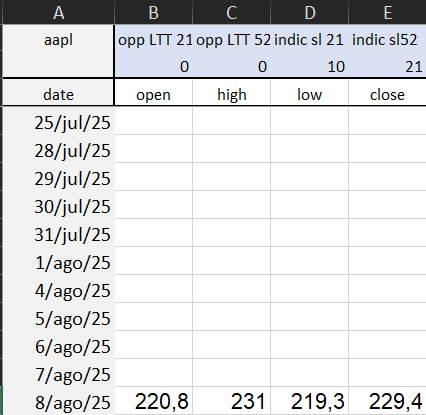

> And to finish off, here is a visual of what this script does once executed!
> * This is an example from a trial run I conducted on August 8th;
> * AAPL's data from this date was successfully appended to the target file!